# Seedbox Data Science Application Test


Candidate name: **Hichem Belattar**

In [1]:
### imports and file loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test_sample = pd.read_csv("testSamples.csv")
trans_data  = pd.read_csv("transData.csv")

In [2]:
### arrays containing the ids of the subject in each group
c_group = test_sample['sample_id'][ test_sample['test_group'] == 0 ].values
t_group = test_sample['sample_id'][ test_sample['test_group'] == 1 ].values

### Question 1. Probability distribution

Customers are randomly assigned to one of the two groups when they connect to the cancellation page of the website for the first time, we notice that it is a behavior of **Bernoulli's law** which is repeated, we deduce that our distribution follows a **Binomial law** which mass function is written as follows:

<img src="https://image.ibb.co/iTTN2T/01.png" alt="01" border="0">

In [3]:
# counting number of customers in both groups
test_sample['test_group'].value_counts() 

0    44886
1    14835
Name: test_group, dtype: int64

In [4]:
# p and (1-p)
test_sample['test_group'].value_counts() / 59721

0    0.751595
1    0.248405
Name: test_group, dtype: float64

** We deduce the probability distribution between the test group and the control group: **

<img src="https://preview.ibb.co/f2UJsT/01.png" alt="01" border="0">

Percentil of test subjects in the test group    : 24.84%
Percentil of test subjects in the control group : 75.16%


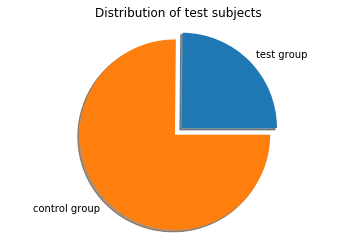

In [5]:
pdf = test_sample['test_group'].mean()

print( "Percentil of test subjects in the test group    : %.2f" %(pdf*100) +'%')
print( "Percentil of test subjects in the control group : %.2f" %((1-pdf)*100) +'%')

plt.pie( x=[pdf, 1-pdf], explode=[0.05, 0.05], labels=['test group', 'control group'], shadow=True )
plt.title( 'Distribution of test subjects' )
plt.axis('equal')
plt.show()

### Question 2. Probability to make at least 1 REBILL

In [6]:
# makes a list of the ids that made at least one REBILL
rebills = trans_data['sample_id'][ trans_data['transaction_type'] == 'REBILL' ].values

tr = cr = 0

# the ids are converted to sets for convenience
test_id    = set( t_group )
control_id = set( c_group )

# avoids double counting
for i in rebills :
    if i in control_id :
        cr += 1
        control_id -= set([i])

    elif i in test_id :
        tr += 1
        test_id -= set([i])

This part is made to count the number of subject that made at least one REBILL in each group respectively

We use the **A/B** statistical significance test.

Here the hypothesis (assumptions) are :<br/>
**H_0 : cr=tr **i.e. there is no difference in rebill proportions<br/>
**H_1 : cr<tr **i.e. the test group has proportionaly more rebills than the control group<br/>

In [7]:
# Averages
cr /= len(c_group)
tr /= len(t_group)

# Standard errors (bernouilli distribution)
SE = ( np.sqrt(cr*(1-cr)/len(c_group)),
       np.sqrt(tr*(1-tr)/len(t_group)))

SF = np.sqrt( SE[0]**2 + SE[1]**2 )

# Statistical significance
z  = (tr - cr)/SF
print( f"tr/cr = {tr/cr}  ;  Z = {z}" )

tr/cr = 5.003147695855258  ;  Z = 32.21629567164292


As we see Z >> 2.58 i.e. we are more then 99% confidente that **H_0** is false.<br/>
**We can assert with 99% confidence that a subject that must call_in to cancel is 5 times more likely to have a least one rebill.**

### Question 3. Generation of revenues

In [8]:
c_revenue = trans_data[ trans_data['sample_id'].isin(c_group) ]['transaction_amount']
t_revenue = trans_data[ trans_data['sample_id'].isin(t_group) ]['transaction_amount']

# Averages
cr = np.mean(c_revenue)
tr = np.mean(t_revenue)

# Standard errors
SE = ( np.std(c_revenue)/np.sqrt(len(c_group)), 
       np.std(t_revenue)/np.sqrt(len(t_group)))

SF = np.sqrt( SE[0]**2 + SE[1]**2 )

# Statistical significance
z  = (tr - cr)/SF
print( f"tr/cr = {tr/cr}  ;  Z = {z}" )

tr/cr = 1.2728427376127638  ;  Z = 42.62142397442697


For revenue generation, we compute the average revenue generated in each group then scale it between [0,1] to make the calculation possible using the same **A/B** statistical test.

**H_0 : cr=tr ** i.e. there is no difference in revenue generation<br/> **H_1 : cr<tr ** i.e. a test subject that has to call-in generates more revenue

We see that Z >> 2.58, we can then assert with 99% confidence that H_0 is false.<br/>
** In conclusion: a subject that has to call-in to cancel will generate around 3 times more revenu, with 99% confidence rate.**

### Question 4. CHARGEBACKs/REBILLs

In [9]:
# list of the number of transaction given theyre type, made by each subject
trans = [ trans_data[ trans_data['sample_id'].isin(c_group) ].groupby(['sample_id','transaction_type']).size(),
          trans_data[ trans_data['sample_id'].isin(t_group) ].groupby(['sample_id','transaction_type']).size() ]

# array of the ids that actually made a transaction
relevent_id = trans_data['sample_id'].values

rate = [ 0, 0 ]
par  = ['CHARGEBACK', 'REBILL']

The code below is entended to compute the CHARGEBACKs/REBILLs rate for each subject that made at least one rebill (otherwise it would be a division by 0), hence the try/except loop. Then we add that rate to its group's.

In [10]:
for n, i in enumerate([c_group, t_group]) :
    for j in i :
        if j in relevent_id :
            var = [0,0]
            
            for m, p in enumerate(par) :
                try :
                    var[m] = trans[n][j, p]
                except :
                    continue
            
            if var[1] == 0 :
                continue
            
            ch, re = var
            rate[n] += ch/re

In [11]:
# Averages
cr, tr = rate
cr /= len(c_group)
tr /= len(t_group)

# Standard errors
SE = ( np.std(rate[0])/np.sqrt(len(c_group)),
       np.std(rate[1])/np.sqrt(len(t_group)))

SF = np.sqrt( SE[0]**2 + SE[1]**2 )

# Statistical significance
# an epsilon is added to avoid dividing by zero
z  = (tr - cr)/(SF+1e-8)
print( f"tr/cr = {tr/cr}  ;  Z = {z}" )

tr/cr = 12.859150657229526  ;  Z = 35227.4670861873


Again we use **A/B** statistical significance test after adjusting for sample size.

**H_0** : CHARGEBACKs/REBILLs rate is identical for both groups.<br/>
**H_1** : the test group has a higher CHARGEBACKs/REBILLs rate.

Z >> 2.58 implies **H_0** is false with 99% confidence.<br/>
**Hence, a subject that has to call-in to cancel will on average produce a higher chargeback rate.**